In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.linear_model as linear_model
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy.linalg import svd
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

data_by_major_df = pd.read_csv("./CollegeScorecard_Raw_Data_03142022/Most-Recent-Cohorts-Field-of-Study.csv")
columns_to_keep = ['UNITID', 'OPEID6', 'INSTNM', 'MAIN', 'CIPCODE', 'CIPDESC', 'CREDLEV','EARN_COUNT_NE_3YR', 'EARN_NE_MDN_3YR']
data_by_major_df = data_by_major_df[columns_to_keep]
data_by_major_df.shape

(224849, 9)

In [65]:
data_duq = data_by_major_df[data_by_major_df["INSTNM"]=='Duquesne University']
data_duq.head()

,UNITID,OPEID6,INSTNM,MAIN,CIPCODE,CIPDESC,CREDLEV,EARN_COUNT_NE_3YR,EARN_NE_MDN_3YR
144838,212106.0,3258,Duquesne University,1,301,Natural Resources Conservation and Research.,3,PrivacySuppressed,PrivacySuppressed
144839,212106.0,3258,Duquesne University,1,301,Natural Resources Conservation and Research.,5,PrivacySuppressed,PrivacySuppressed
144840,212106.0,3258,Duquesne University,1,301,Natural Resources Conservation and Research.,8,PrivacySuppressed,PrivacySuppressed
144841,212106.0,3258,Duquesne University,1,501,Area Studies.,3,PrivacySuppressed,PrivacySuppressed
144842,212106.0,3258,Duquesne University,1,502,"Ethnic, Cultural Minority, Gender, and Group S...",3,PrivacySuppressed,PrivacySuppressed


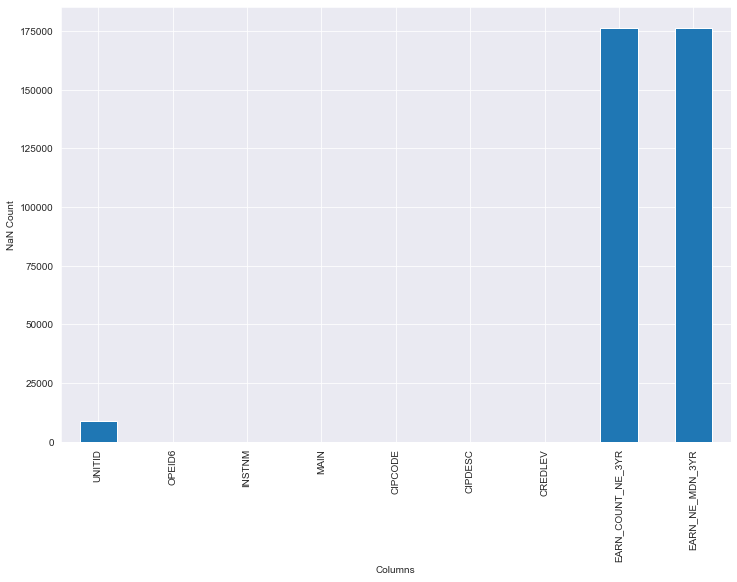

In [66]:
# Replacing all rows that have values suppressed for privacy reasons with np.nan
data_by_major_df = data_by_major_df.replace("PrivacySuppressed", np.nan)
# data_by_major_df['EARN_COUNT_NE_3YR'].isna().sum()

plt.figure(figsize=(12,8))
plt.xlabel("Columns")
plt.ylabel("NaN Count")
data_by_major_df.isna().sum().plot(kind='bar')
plt.show()

In [67]:
# Removing NaN values
data_by_major_df = data_by_major_df[~data_by_major_df["EARN_NE_MDN_3YR"].isna()]
# Replacing the values in count column that are PrivacySuppressed by the median count value
data_by_major_df['EARN_COUNT_NE_3YR'] = data_by_major_df['EARN_COUNT_NE_3YR'].fillna(data_by_major_df['EARN_COUNT_NE_3YR'].median())

In [68]:
# CREDLEV column mapped with what it denotes
degree_mapping = {3: 'Bachelor\x92s Degree', 5: "Master's Degree", 8: 'Graduate/Professional Certificate',\
                  7: 'First Professional Degree', 6: 'Doctoral Degree', 2: "Associate's Degree",\
                  1: 'Undergraduate Certificate or Diploma', 4: 'Post-baccalaureate Certificate'}

# Mapping CIPCODE and CIPDESC
major_codes = data_by_major_df[["CIPCODE", "CIPDESC"]].to_dict(orient='list')

major_mapping = {}

for i in range(len(major_codes["CIPCODE"])):
    if major_codes["CIPCODE"][i] in major_mapping:
        continue
    else:
        major_mapping[major_codes["CIPCODE"][i]] = major_codes["CIPDESC"][i]
        
# Removing rows where UNITID is not present as unable to figure out the university without UNITID
data_by_major_df = data_by_major_df[~data_by_major_df["UNITID"].isna()]

In [69]:
data_by_major_df

,UNITID,OPEID6,INSTNM,MAIN,CIPCODE,CIPDESC,CREDLEV,EARN_COUNT_NE_3YR,EARN_NE_MDN_3YR
14,100654.0,1002,Alabama A & M University,1,1101,"Computer and Information Sciences, General.",3,29,65291
22,100654.0,1002,Alabama A & M University,1,1312,Teacher Education and Professional Development...,5,17,50627
23,100654.0,1002,Alabama A & M University,1,1313,Teacher Education and Professional Development...,3,29,33058
27,100654.0,1002,Alabama A & M University,1,1410,"Electrical, Electronics and Communications Eng...",3,32,70691
28,100654.0,1002,Alabama A & M University,1,1419,Mechanical Engineering.,3,24,62771
...,...,...,...,...,...,...,...,...,...
215910,494852.0,4866,Stautzenberger College-Rockford Career College,0,5107,Health and Medical Administrative Services.,2,33,25329
215912,494852.0,4866,Stautzenberger College-Rockford Career College,0,5135,Somatic Bodywork and Related Therapeutic Servi...,1,51,19379
215915,494898.0,39704,WellSpring School of Allied Health-Wichita,0,5108,Allied Health and Medical Assisting Services.,1,29,22901
215917,494898.0,39704,WellSpring School of Allied Health-Wichita,0,5135,Somatic Bodywork and Related Therapeutic Servi...,1,104,19637


In [70]:
# Rolling up the CIPDESC and CIPCODES to higher categories so that they can they be used as features
higher_level_major_mapping = {1: "AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",
                              3: "NATURAL RESOURCES AND CONSERVATION", 
                              4: "ARCHITECTURE AND RELATED SERVICES",
                              5: "AREA, ETHNIC, CULTURAL, AND GENDER STUDIES", 
                              9: "COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS", 
                              10: "COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES", 
                              11: "COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES",            
                              12: "PERSONAL AND CULINARY SERVICES", 
                              13: "EDUCATION", 
                              14: "ENGINEERING",
                              15: "ENGINEERING TECHNOLOGIES TECHNICIANS", 
                              16: "FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS", 
                              19: "FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES", 
                              22: "LEGAL PROFESSIONS AND STUDIES", 
                              23: "ENGLISH LANGUAGE AND LITERATURE/LETTERS", 
                              24: "LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",
                              25: "LIBRARY SCIENCE", 
                              26: "BIOLOGICAL AND BIOMEDICAL SCIENCES", 
                              27: "MATHEMATICS AND STATISTICS", 
                              28: "RESERVE OFFICER TRAINING CORPS", 
                              29: "MILITARY TECHNOLOGIES", 
                              30: "MULTI/INTERDISCIPLINARY STUDIES", 
                              31: "PARKS, RECREATION, LEISURE, AND FITNESS STUDIES", 
                              32: "BASIC SKILLS", 
                              33: "CITIZENSHIP ACTIVITIES", 
                              34: "HEALTH-RELATED KNOWLEDGE AND SKILLS", 
                              35: "INTERPERSONAL AND SOCIAL SKILLS", 
                              36: "LEISURE AND RECREATIONAL ACTIVITIES", 
                              37: "PERSONAL AWARENESS AND SELF-IMPROVEMENT", 
                              38: "PHILOSOPHY AND RELIGIOUS STUDIES", 
                              39: "THEOLOGY AND RELIGIOUS VOCATIONS", 
                              40: "PHYSICAL SCIENCES", 
                              41: "SCIENCE TECHNOLOGIES/TECHNICIANS", 
                              42: "PSYCHOLOGY", 
                              43: "SECURITY AND PROTECTIVE SERVICES", 
                              44: "PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS", 
                              45: "SOCIAL SCIENCES", 
                              46: "CONSTRUCTION TRADES", 
                              47: "MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS", 
                              48: "PRECISION PRODUCTION", 
                              49: "TRANSPORTATION AND MATERIALS MOVING", 
                              50: "VISUAL AND PERFORMING ARTS", 
                              51: "HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES", 
                              52: "BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES", 
                              53: "HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES", 
                              54: "HISTORY", 
                              60: "Residency Programs"}

In [71]:
def higher_level_mapping(cipcode):

    for code in higher_level_major_mapping:
        if str(cipcode).startswith(str(code)) and len(str(cipcode)) == 3 and len(str(code)) == 1:
            return higher_level_major_mapping[code]
            
        if str(cipcode).startswith(str(code)) and len(str(cipcode)) == 4 and len(str(code)) == 2:
            return higher_level_major_mapping[code]
        
    return np.nan

In [72]:
data_by_major_df["CIPDESC_NEW"] = data_by_major_df["CIPCODE"].apply(lambda x: higher_level_mapping(x))
data_by_major_df["CIPDESC_NEW"] = np.where(data_by_major_df["CIPDESC_NEW"].isna(), data_by_major_df["CIPDESC"], data_by_major_df["CIPDESC_NEW"])

# One-hot encoding of CREDLEV and CIPDESC_NEW
data_by_major_df = pd.concat([data_by_major_df, pd.get_dummies(data_by_major_df["CREDLEV"], prefix="CREDLEV_")], axis=1)

data_by_major_df = pd.concat([data_by_major_df, pd.get_dummies(data_by_major_df["CIPDESC_NEW"], prefix="CIPDESC_")], axis=1)


In [73]:
# Dropping columns that are not needed now
data_by_major_df = data_by_major_df.drop(columns="CIPDESC")
data_by_major_df = data_by_major_df.drop(columns="CIPDESC_NEW")
data_by_major_df = data_by_major_df.drop(columns="CREDLEV")
data_by_major_df = data_by_major_df.drop(columns="OPEID6")
data_by_major_df = data_by_major_df.drop(columns="MAIN")
data_by_major_df = data_by_major_df.drop(columns="INSTNM")
data_by_major_df = data_by_major_df.drop(columns="CIPCODE")

data_by_major_df["UNITID"] = data_by_major_df["UNITID"].astype(int) 
data_by_major_df["EARN_COUNT_NE_3YR"] = data_by_major_df["EARN_COUNT_NE_3YR"].astype(int) 
data_by_major_df["EARN_NE_MDN_3YR"] = data_by_major_df["EARN_NE_MDN_3YR"].astype(float) 

data_by_major_df.shape

(47566, 54)

In [74]:
data_by_major_df

,UNITID,EARN_COUNT_NE_3YR,EARN_NE_MDN_3YR,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS
14,100654,29,65291.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,100654,17,50627.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,100654,29,33058.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,100654,32,70691.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28,100654,24,62771.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215910,494852,33,25329.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
215912,494852,51,19379.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
215915,494898,29,22901.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
215917,494898,104,19637.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
data_by_major_df["EARN_NE_MDN_3YR"].describe()


count     47566.000000
mean      47348.547723
std       22455.157893
min           0.000000
25%       32804.000000
50%       42897.000000
75%       57570.000000
max      267734.000000
Name: EARN_NE_MDN_3YR, dtype: float64

### Reading file that contains data by college/university


In [76]:
data_by_institution_df = pd.read_csv("./CollegeScorecard_Raw_Data_03142022/Most-Recent-Cohorts-Institution.csv")
data_by_institution_df.shape


(6694, 2989)

In [77]:
root_columns_to_keep = ["UNITID", "OPEID", "OPEID6"]

school_columns_to_keep = ["INSTNM", "MAIN", "CONTROL", "REGION", "LOCALE", \
                          "CCBASIC", "DISTANCEONLY", "CURROPER", "TUITFTE", "INEXPFTE", "OPENADMP"]
# can add more
student_columns_to_keep = ["UGDS", "DEP_INC_AVG", "IND_INC_AVG", "AGE_ENTRY",\
                           "INC_N", "UGDS_WOMEN"]
# can add more features
# removed becaue near 90% missing values
# admissions_columns_to_keep = ["ADM_RATE", "SAT_AVG", "SATVR75", "SATMT75", "SATWR75", "ACTCM75"]

aid_columns_to_keep = ["PCTPELL", "PCTFLOAN"]

# earnings_columns_to_keep = ["MD_EARN_WNE_P6", "MD_EARN_WNE_P8", "MD_EARN_WNE_P10"]

In [78]:
all_columns_to_keep = []

all_columns_to_keep.extend(root_columns_to_keep)
all_columns_to_keep.extend(school_columns_to_keep)
all_columns_to_keep.extend(student_columns_to_keep)
all_columns_to_keep.extend(aid_columns_to_keep)

# all_columns_to_keep.extend(earnings_columns_to_keep)

data_by_institution_df_new = data_by_institution_df[all_columns_to_keep]
data_by_institution_df_new = data_by_institution_df_new.replace("PrivacySuppressed", np.nan)
data_by_institution_df_new["OPENADMP"] = data_by_institution_df_new["OPENADMP"].fillna(0)

all_columns_to_keep


['UNITID',
 'OPEID',
 'OPEID6',
 'INSTNM',
 'MAIN',
 'CONTROL',
 'REGION',
 'LOCALE',
 'CCBASIC',
 'DISTANCEONLY',
 'CURROPER',
 'TUITFTE',
 'INEXPFTE',
 'OPENADMP',
 'UGDS',
 'DEP_INC_AVG',
 'IND_INC_AVG',
 'AGE_ENTRY',
 'INC_N',
 'UGDS_WOMEN',
 'PCTPELL',
 'PCTFLOAN']

In [79]:
# one-hot encoding several college features
data_by_institution_df_new = pd.concat([data_by_institution_df_new, pd.get_dummies(data_by_institution_df_new["MAIN"]\
                                                                                   , prefix="MAIN_")], axis=1)
data_by_institution_df_new = pd.concat([data_by_institution_df_new, pd.get_dummies(data_by_institution_df_new["CONTROL"]\
                                                                                   , prefix="CONTROL_")], axis=1)
data_by_institution_df_new = pd.concat([data_by_institution_df_new, pd.get_dummies(data_by_institution_df_new["REGION"]\
                                                                                   , prefix="REGION_")], axis=1)
data_by_institution_df_new = pd.concat([data_by_institution_df_new, pd.get_dummies(data_by_institution_df_new["LOCALE"]\
                                                                                   , prefix="LOCALE_")], axis=1)
data_by_institution_df_new = pd.concat([data_by_institution_df_new, pd.get_dummies(data_by_institution_df_new["CCBASIC"]\
                                                                                   , prefix="CCBASIC_")], axis=1)
data_by_institution_df_new = pd.concat([data_by_institution_df_new, \
                        pd.get_dummies(data_by_institution_df_new["DISTANCEONLY"], prefix="DISTANCEONLY_")], axis=1)
data_by_institution_df_new = pd.concat([data_by_institution_df_new, \
                        pd.get_dummies(data_by_institution_df_new["CURROPER"], prefix="CURROPER_")], axis=1)
data_by_institution_df_new = pd.concat([data_by_institution_df_new, \
                        pd.get_dummies(data_by_institution_df_new["OPENADMP"], prefix="OPENADMP_")], axis=1)

In [80]:
data_by_institution_df_new = data_by_institution_df_new.drop(columns="MAIN")
data_by_institution_df_new = data_by_institution_df_new.drop(columns="CONTROL")
data_by_institution_df_new = data_by_institution_df_new.drop(columns="REGION")
data_by_institution_df_new = data_by_institution_df_new.drop(columns="LOCALE")
data_by_institution_df_new = data_by_institution_df_new.drop(columns="CCBASIC")
data_by_institution_df_new = data_by_institution_df_new.drop(columns="DISTANCEONLY")
data_by_institution_df_new = data_by_institution_df_new.drop(columns="CURROPER")
data_by_institution_df_new = data_by_institution_df_new.drop(columns="OPENADMP")
data_by_institution_df_new.head()


,UNITID,OPEID,OPEID6,INSTNM,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0
0,100654,100200,1002,Alabama A & M University,7870.0,5546.0,5271.0,34779.085684,10340.346032,20.283741368,3186,0.6033,0.7019,0.7361,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
1,100663,105200,1052,University of Alabama at Birmingham,12096.0,14983.0,13328.0,61110.800384,30607.18029,23.60797466,5367,0.6110,0.3512,0.4798,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
2,100690,2503400,25034,Amridge University,16403.0,5245.0,365.0,25211.032258,20596.158491,33.672297297,296,0.7068,0.6382,0.7009,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3,100706,105500,1055,University of Alabama in Huntsville,8275.0,8488.0,7785.0,72240.892617,27941.821963,22.727919632,2389,0.4190,0.2536,0.3976,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
4,100724,100500,1005,Alabama State University,9587.0,9346.0,3750.0,34468.571812,8551.802974,20.130990415,2504,0.6309,0.7627,0.8232,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1


In [81]:
data_by_institution_df_new.shape


(6694, 83)

### Merging the 2 dataframes


In [82]:
merged_df = pd.merge(data_by_major_df, data_by_institution_df_new, on="UNITID", how="left")
# Removing nan values
merged_df = merged_df.replace("PrivacySuppressed", np.nan)
# Removing rows that have more than 50% nan values
merged_df = merged_df[merged_df.isna().mean(axis=1) < 0.5]
merged_df = merged_df[~merged_df["PCTPELL"].isna()]
merged_df = merged_df[~merged_df["DEP_INC_AVG"].isna()]
merged_df = merged_df[~merged_df["UGDS_WOMEN"].isna()]
merged_df = merged_df[~merged_df["TUITFTE"].isna()]
merged_df["DEP_INC_AVG"] = merged_df["DEP_INC_AVG"].astype(float) 
merged_df["IND_INC_AVG"] = merged_df["IND_INC_AVG"].astype(float) 
merged_df["AGE_ENTRY"] = merged_df["AGE_ENTRY"].astype(float) 
merged_df["INC_N"] = merged_df["INC_N"].astype(float)


In [83]:
merged_df

,UNITID,EARN_COUNT_NE_3YR,EARN_NE_MDN_3YR,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS,OPEID,OPEID6,INSTNM,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0
0,100654,29,65291.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100200.0,1002.0,Alabama A & M University,7870.0,5546.0,5271.0,34779.085684,10340.346032,20.283741,3186.0,0.6033,0.7019,0.7361,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,100654,17,50627.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100200.0,1002.0,Alabama A & M University,7870.0,5546.0,5271.0,34779.085684,10340.346032,20.283741,3186.0,0.6033,0.7019,0.7361,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [84]:
# Mapping college UNITID and its name
college_unit_id = merged_df[["UNITID", "INSTNM"]].to_dict(orient='list')

college_mapping = {}

for i in range(len(college_unit_id["UNITID"])):
    if college_unit_id["UNITID"][i] in college_mapping:
        continue
    else:
        college_mapping[college_unit_id["UNITID"][i]] = college_unit_id["INSTNM"][i]

In [85]:
data_duq = merged_df[merged_df['UNITID']==212106]
data_duq

,UNITID,EARN_COUNT_NE_3YR,EARN_NE_MDN_3YR,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS,OPEID,OPEID6,INSTNM,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0
28050,212106,23,35708.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,325800.0,3258.0,Duquesne University,23805.0,12481.0,5837.0,110744.37367,23399.450644,20.384467,2588.0,0.6363,0.1923,0.6202,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
28051,212106,68,44189.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,325800.0,3258.0,Duquesne University,23805.0,12481.0,5837.0,110744.37367,23399.450644,20.384467,2588.0,0.6363,0.1923,0.6202,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [96]:
merged_df = merged_df.drop(columns=["INSTNM", "UNITID", "OPEID", "OPEID6"])

In [ ]:
data_duq = data_duq.drop(columns=["INSTNM", "UNITID", "OPEID", "OPEID6"])

In [86]:
merged_df.shape

(42952, 136)

In [24]:
merged_df


,EARN_COUNT_NE_3YR,EARN_NE_MDN_3YR,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0
0,29,65291.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7870.0,5546.0,5271.0,34779.085684,10340.346032,20.283741,3186.0,0.6033,0.7019,0.7361,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,17,50627.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7870.0,5546.0,5271.0,34779.085684,10340.346032,20.283741,3186.0,0.6033,0.7019,0.7361,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,29,33058.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

### Performing PCA

<Figure size 432x288 with 0 Axes>

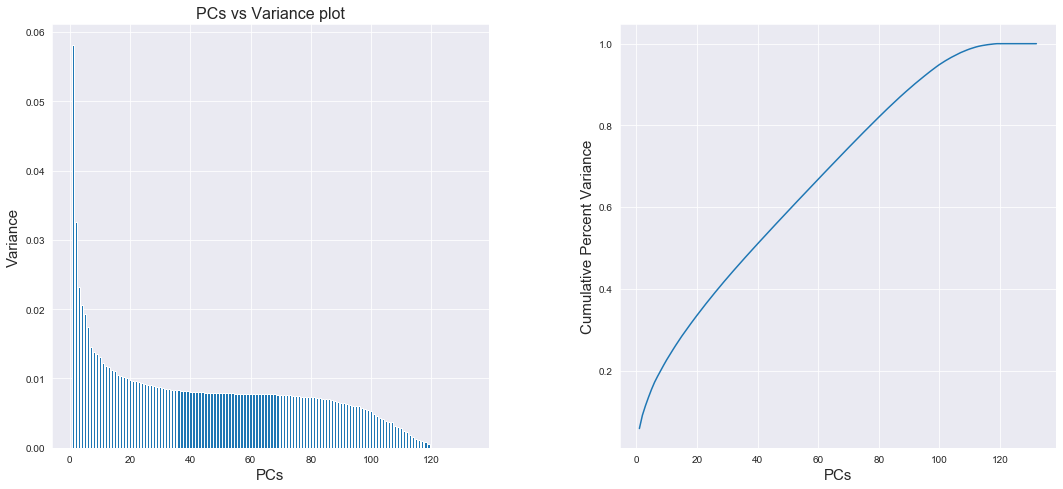

In [25]:
X = merged_df.copy()

# Defining a Standard Scaler object
scaler=StandardScaler()

#Fitting the data to compute the mean and variance for each feature on the training set
scaler.fit(X)

## Fitting
scaled_X = scaler.transform(X)

## Defining a PCA object
pca = PCA(n_components=scaled_X.shape[1])
principalComponents = pca.fit(scaled_X)

## Variance
pcs_var = principalComponents.explained_variance_ratio_
cum_var = np.cumsum(pcs_var)
pcs = range(1, scaled_X.shape[1]+1)

sns.set_style('darkgrid')


fig = plt.figure()
plt.figure(figsize=(18,6))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.2, wspace=0.3)

## PCs vs Variance plot
plt.subplot(1, 2, 1)
plt.title('PCs vs Variance plot', fontsize = 16)
plt.xlabel('PCs', fontsize = 15)
plt.ylabel('Variance', fontsize = 15)
plt.bar(pcs, pcs_var)

## Scree Plot
plt.subplot(1, 2, 2)
plt.xlabel('PCs', fontsize = 15)
plt.ylabel('Cumulative Percent Variance', fontsize = 15)
plt.plot(pcs, cum_var)
plt.show()

### Logistic Regression

In [101]:
merged_df_logistic = merged_df.copy()
merged_df_logistic.head()


,EARN_COUNT_NE_3YR,EARN_NE_MDN_3YR,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0
0,29,65291.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7870.0,5546.0,5271.0,34779.085684,10340.346032,20.283741,3186.0,0.6033,0.7019,0.7361,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,17,50627.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7870.0,5546.0,5271.0,34779.085684,10340.346032,20.283741,3186.0,0.6033,0.7019,0.7361,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,29,33058.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

In [102]:
merged_df_logistic["EARN_NE_MDN_3YR"].describe()


count     42952.000000
mean      47959.702831
std       22400.697169
min           0.000000
25%       33603.000000
50%       43476.000000
75%       58127.000000
max      267734.000000
Name: EARN_NE_MDN_3YR, dtype: float64

In [103]:
merged_df_logistic["Income Greater than Median"] = np.where(merged_df_logistic["EARN_NE_MDN_3YR"] >= \
                                                            merged_df_logistic["EARN_NE_MDN_3YR"].median(), 1, 0)
merged_df_logistic = merged_df_logistic.drop(columns="EARN_NE_MDN_3YR")

def standardize(column):
    column = ((column - np.mean(column))/np.std(column))
    return column

In [104]:
key_ele = ["TUITFTE", "INEXPFTE", "UGDS","DEP_INC_AVG", "IND_INC_AVG","AGE_ENTRY","INC_N","EARN_COUNT_NE_3YR","UGDS_WOMEN","PCTPELL", "PCTFLOAN"]

for i in key_ele:
    merged_df_logistic[i] = standardize(merged_df_logistic[i])
merged_df_logistic


,EARN_COUNT_NE_3YR,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0,Income Greater than Median
0,-0.240355,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.488258,-0.482656,-0.398658,-1.146252,-1.699884,-1.012387,-0.359243,0.101634,1.830203,1.337409,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1
1,-0.271433,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.488258,-0.482656,-0.398658,-1.146252,-1.699884,-1.012387,-0.359243,0.101634,1.830203,1.337409,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1
2,-0.240355,0,0,1,0,0,0,0,0,0,0,0,0,

In [105]:
Y_log = merged_df_logistic[["Income Greater than Median"]]
X_log = merged_df_logistic.drop(columns="Income Greater than Median")

X_train = X_log[:int(0.7*X_log.shape[0])] 
X_test = X_log[int(0.7*X_log.shape[0]):]
Y_train = Y_log[:int(0.7*Y_log.shape[0])]
Y_test = Y_log[int(0.7*Y_log.shape[0]):]
X_train.shape, X_test.shape


((30066, 131), (12886, 131))

In [106]:
Y_train.shape, Y_test.shape


((30066, 1), (12886, 1))

In [107]:
# logistic regression
cls = linear_model.LogisticRegression().fit(X_train, Y_train)

y_pred_LogRE = cls.predict(X_test)
print(accuracy_score(Y_test, y_pred_LogRE))


0.8209684929380723


In [123]:
data_duq.drop(columns="EARN_NE_MDN_3YR").isna().sum().sum()

410

In [126]:
X_duq.shape

(41, 131)

In [131]:
cls.coef_.transpose()+cls.intercept_

array([[ 0.5181232 ],
       [-3.14895579],
       [-2.23634688],
       [-1.26053989],
       [ 0.13235553],
       [ 1.41214616],
       [ 3.27191586],
       [ 2.66002114],
       [ 2.111868  ],
       [ 0.15336619],
       [ 2.81886905],
       [-1.36821908],
       [ 0.24725538],
       [-1.01941794],
       [ 1.9335397 ],
       [-0.24941094],
       [-0.92500836],
       [ 2.88388833],
       [ 3.00003219],
       [-0.43861541],
       [ 5.51810075],
       [ 3.89031658],
       [-2.09340191],
       [-0.57152345],
       [-1.5293044 ],
       [ 2.60019398],
       [ 0.08638837],
       [ 0.41487826],
       [-1.82246278],
       [ 0.27176013],
       [-0.12577   ],
       [-1.36825609],
       [-0.60992927],
       [ 2.249476  ],
       [ 2.41392322],
       [ 1.13109374],
       [-0.41900982],
       [-0.54270976],
       [-1.02555159],
       [-0.84582467],
       [-2.23467301],
       [ 1.34989163],
       [ 1.8988009 ],
       [-1.56684641],
       [-0.31930276],
       [ 0

In [129]:
dir(cls)

cls.intercept_
cls.coef_.shape

(1, 131)

In [125]:
for i in key_ele:
    data_duq[i] = standardize(data_duq[i])
data_duq.head()
X_duq = np.array(data_duq.drop(columns="EARN_NE_MDN_3YR"))
cls.predict(X_duq)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

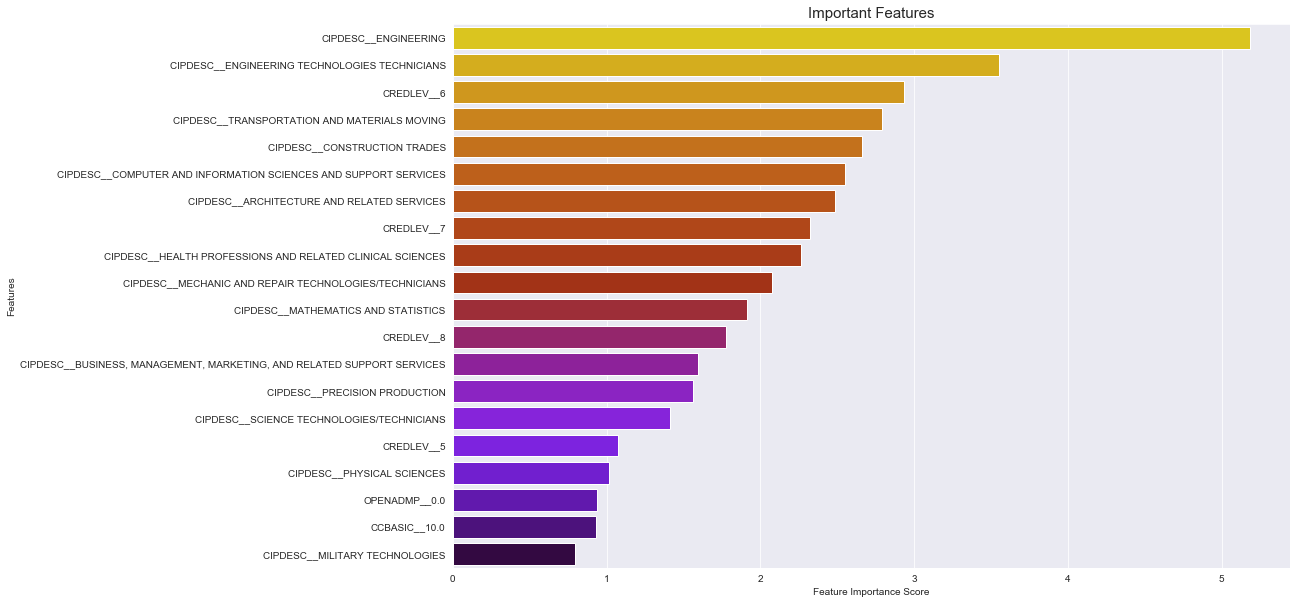

In [33]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, Y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(Y_test["Income Greater than Median"], model_pred)
    
    # Return the performance metric
    return model_mae

coefs = pd.Series(cls.coef_[0], index=X_train.columns)
coefs = coefs.sort_values()

def plot_imp_features(feature_imp):
    plt.figure(figsize=(15,10))
    
    sns.barplot(x=feature_imp, y=feature_imp.index, palette = sns.color_palette('gnuplot_r', len(feature_imp)))
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Important Features", fontsize = 15)
    plt.show()

feature_imp_positive = pd.Series(coefs, index=list(X_train.columns)).sort_values(ascending=False)[:20]
feature_imp_negative = pd.Series(coefs, index=list(X_train.columns)).sort_values()[:20]

plot_imp_features(feature_imp_positive)


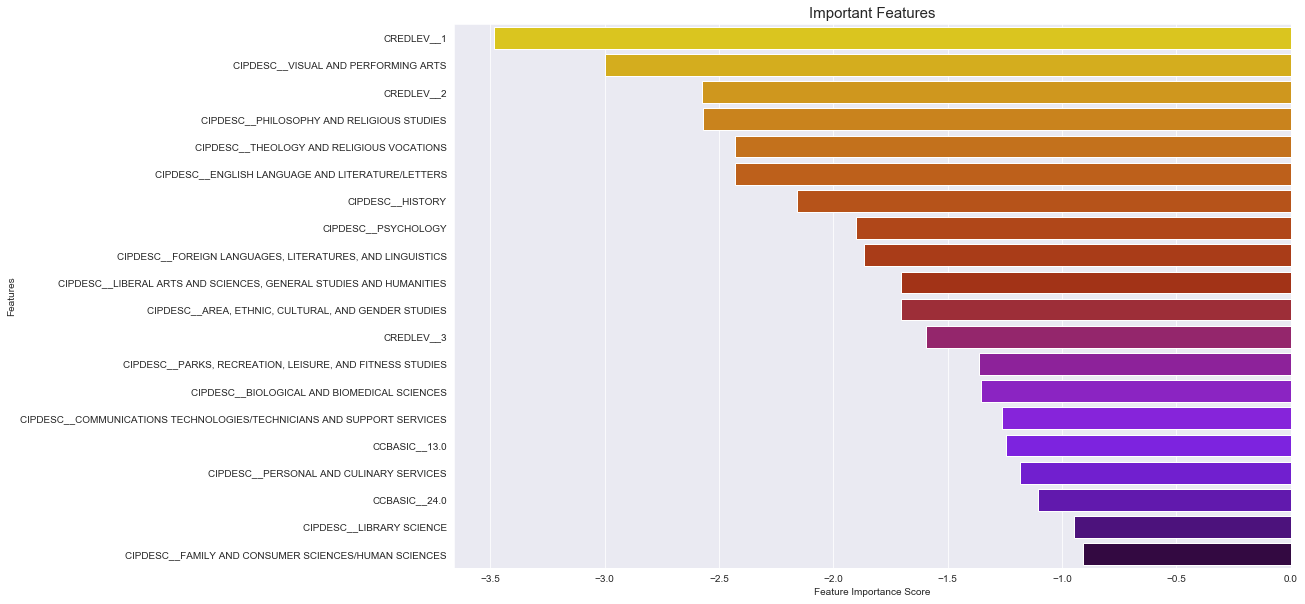

In [34]:
plot_imp_features(feature_imp_negative)


### Multinomial Logistic Regression


In [35]:
merged_df_multi_logistic = merged_df.copy()
merged_df_multi_logistic["EARN_NE_MDN_3YR"].describe()


count     42952.000000
mean      47959.702831
std       22400.697169
min           0.000000
25%       33603.000000
50%       43476.000000
75%       58127.000000
max      267734.000000
Name: EARN_NE_MDN_3YR, dtype: float64

In [36]:
merged_df_multi_logistic["EARN_NE_MDN_3YR"].value_counts()

0.0        57
48261.0    22
40878.0    21
44776.0    20
19115.0    19
           ..
56049.0     1
41189.0     1
60766.0     1
57769.0     1
53878.0     1
Name: EARN_NE_MDN_3YR, Length: 28639, dtype: int64

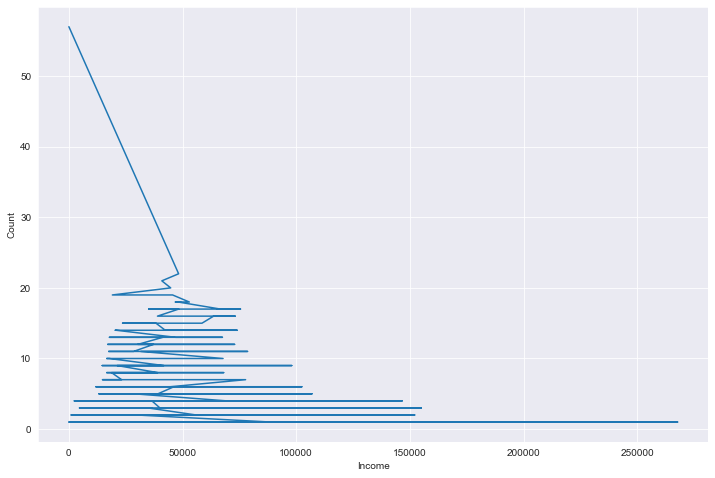

In [37]:
plt.figure(figsize=(12,8))
merged_df_multi_logistic["EARN_NE_MDN_3YR"].value_counts().plot(kind='line')
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()

In [38]:
merged_df_multi_logistic["Income Class"] = np.where(merged_df_multi_logistic["EARN_NE_MDN_3YR"] < 30000, 0, \
np.where((merged_df_multi_logistic["EARN_NE_MDN_3YR"] >= 30000) & (merged_df_multi_logistic["EARN_NE_MDN_3YR"] < 60000), 1, 2))

# delet columns=EARN_NE_MDN_3YR
merged_df_multi_logistic = merged_df_multi_logistic.drop(columns="EARN_NE_MDN_3YR")

merged_df_multi_logistic.head()



,EARN_COUNT_NE_3YR,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0,Income Class
0,29,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7870.0,5546.0,5271.0,34779.085684,10340.346032,20.283741,3186.0,0.6033,0.7019,0.7361,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2
1,17,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7870.0,5546.0,5271.0,34779.085684,10340.346032,20.283741,3186.0,0.6033,0.7019,0.7361,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1
2,29,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [39]:
def standardize(column):
    column = ((column - np.mean(column))/np.std(column))
    return column

key_ele = ["TUITFTE", "INEXPFTE", "UGDS","DEP_INC_AVG", "IND_INC_AVG","AGE_ENTRY","INC_N","EARN_COUNT_NE_3YR","UGDS_WOMEN","PCTPELL", "PCTFLOAN"]

for i in key_ele:
    merged_df_multi_logistic[i] = standardize(merged_df_multi_logistic[i])
merged_df_logistic

Y_multi_log = merged_df_multi_logistic[["Income Class"]]
X_multi_log = merged_df_multi_logistic.drop(columns="Income Class")

X_train = X_multi_log[:int(0.7*X_multi_log.shape[0])] 
X_test = X_multi_log[int(0.7*X_multi_log.shape[0]):]

Y_train = Y_multi_log[:int(0.7*Y_multi_log.shape[0])]
Y_test = Y_multi_log[int(0.7*Y_multi_log.shape[0]):]

X_train.shape, Y_train.shape

((30066, 131), (30066, 1))

In [40]:
X_train.shape, Y_train.shape

((30066, 131), (30066, 1))

In [41]:
X_train.head()

,EARN_COUNT_NE_3YR,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0
0,-0.240355,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.488258,-0.482656,-0.398658,-1.146252,-1.699884,-1.012387,-0.359243,0.101634,1.830203,1.337409,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.271433,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.488258,-0.482656,-0.398658,-1.146252,-1.699884,-1.012387,-0.359243,0.101634,1.830203,1.337409,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,-0.240355,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0

In [42]:
Y_train.head()

,Income Class
0,2
1,1
2,1
3,2
4,2


In [43]:
# logistic regression
cls_multi = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, Y_train)

# cls.fit(X_train, Y_train)
y_pred = cls_multi.predict(X_test)

print(accuracy_score(Y_test, y_pred))
# print(fit_and_evaluate(cls_multi)) #error

0.7572559366754618


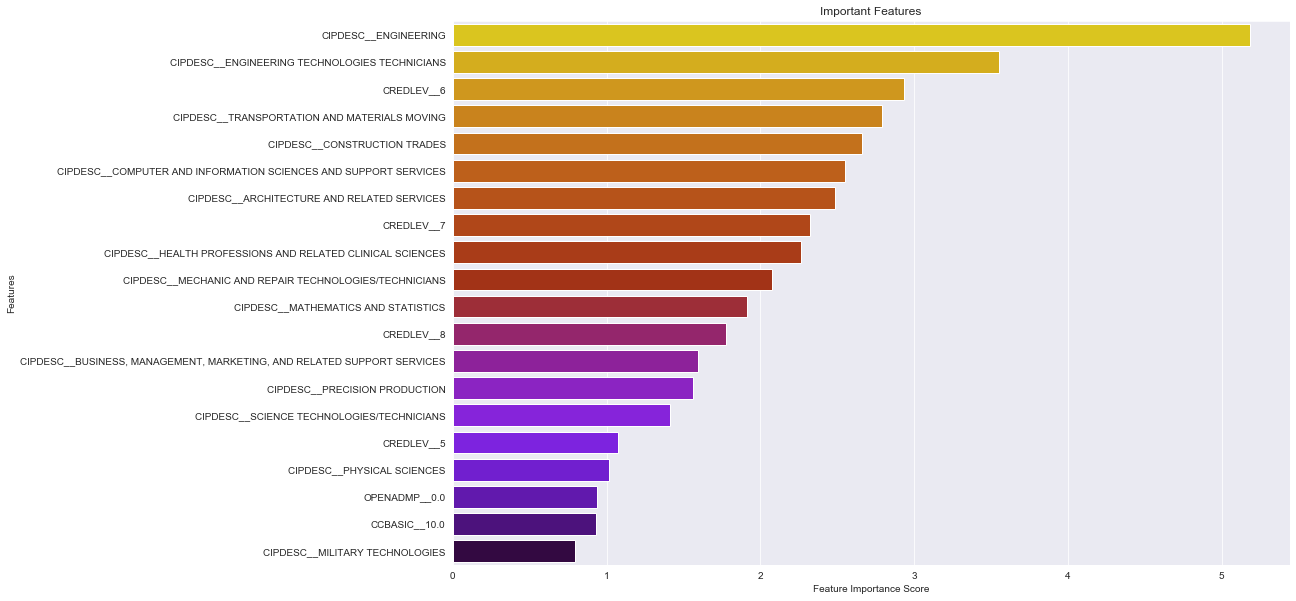

In [44]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
coefs = coefs.sort_values()

def plot_imp_features(feature_imp):
    plt.figure(figsize=(15,10))
    sns.barplot(x=feature_imp, y=feature_imp.index, palette = sns.color_palette('gnuplot_r', len(feature_imp))) 
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Important Features")
    plt.show()

    
feature_imp_positive = pd.Series(coefs, index=list(X_train.columns)).sort_values(ascending=False)[:20]
feature_imp_negative = pd.Series(coefs, index=list(X_train.columns)).sort_values()[:20]

plot_imp_features(feature_imp_positive)


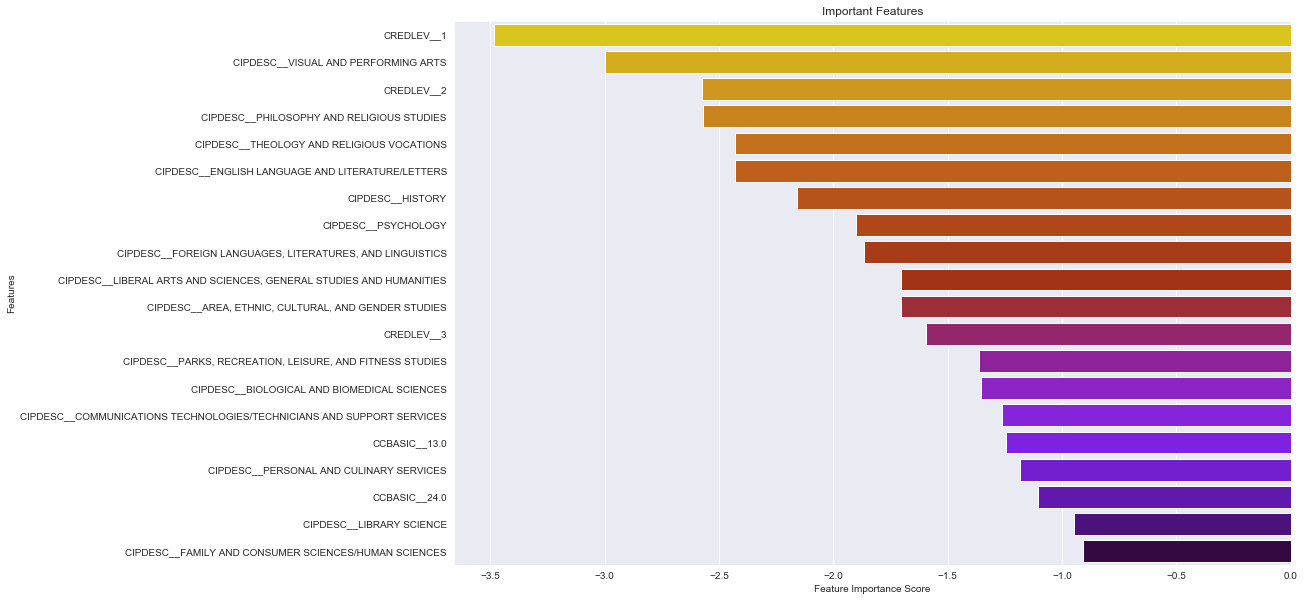

In [45]:
plot_imp_features(feature_imp_negative)


## Then I moved towards actual student income prediction, now that I had a sense of what features were more important in determining the student income. I performed simple linear regression, sparse regression and then decision tree as well as random forest regression. Sparse regression (LASSO) gave me the best results for the student income with a RMSE of approximately 12000.


In [46]:
merged_df_new = merged_df.copy()
def standardize(column):
    #column = ((column - np.mean(column))/np.std(column))
    column = (column - np.min(column))/(np.max(column)-np.min(column))
    return column

key_ele = ["TUITFTE", "INEXPFTE", "UGDS","DEP_INC_AVG", "IND_INC_AVG","AGE_ENTRY","INC_N","EARN_COUNT_NE_3YR","UGDS_WOMEN","PCTPELL", "PCTFLOAN"]

for i in key_ele:
    merged_df_new[i] = standardize(merged_df_new[i])


merged_df_new.head()


,EARN_COUNT_NE_3YR,EARN_NE_MDN_3YR,CREDLEV__1,CREDLEV__2,CREDLEV__3,CREDLEV__4,CREDLEV__5,CREDLEV__6,CREDLEV__7,CREDLEV__8,"CIPDESC__AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES",CIPDESC__ARCHITECTURE AND RELATED SERVICES,"CIPDESC__AREA, ETHNIC, CULTURAL, AND GENDER STUDIES",CIPDESC__BASIC SKILLS,CIPDESC__BIOLOGICAL AND BIOMEDICAL SCIENCES,"CIPDESC__BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES","CIPDESC__COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS",CIPDESC__COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES,CIPDESC__COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES,CIPDESC__CONSTRUCTION TRADES,CIPDESC__EDUCATION,CIPDESC__ENGINEERING,CIPDESC__ENGINEERING TECHNOLOGIES TECHNICIANS,CIPDESC__ENGLISH LANGUAGE AND LITERATURE/LETTERS,CIPDESC__FAMILY AND CONSUMER SCIENCES/HUMAN SCIENCES,"CIPDESC__FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS",CIPDESC__HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES,CIPDESC__HEALTH-RELATED KNOWLEDGE AND SKILLS,CIPDESC__HIGH SCHOOL/SECONDARY DIPLOMAS AND CERTIFICATES,CIPDESC__HISTORY,CIPDESC__LEGAL PROFESSIONS AND STUDIES,CIPDESC__LEISURE AND RECREATIONAL ACTIVITIES,"CIPDESC__LIBERAL ARTS AND SCIENCES, GENERAL STUDIES AND HUMANITIES",CIPDESC__LIBRARY SCIENCE,CIPDESC__MATHEMATICS AND STATISTICS,CIPDESC__MECHANIC AND REPAIR TECHNOLOGIES/TECHNICIANS,CIPDESC__MILITARY TECHNOLOGIES,CIPDESC__MULTI/INTERDISCIPLINARY STUDIES,CIPDESC__NATURAL RESOURCES AND CONSERVATION,"CIPDESC__PARKS, RECREATION, LEISURE, AND FITNESS STUDIES",CIPDESC__PERSONAL AND CULINARY SERVICES,CIPDESC__PHILOSOPHY AND RELIGIOUS STUDIES,CIPDESC__PHYSICAL SCIENCES,CIPDESC__PRECISION PRODUCTION,CIPDESC__PSYCHOLOGY,CIPDESC__PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS,CIPDESC__Residency Programs,CIPDESC__SCIENCE TECHNOLOGIES/TECHNICIANS,CIPDESC__SECURITY AND PROTECTIVE SERVICES,CIPDESC__SOCIAL SCIENCES,CIPDESC__THEOLOGY AND RELIGIOUS VOCATIONS,CIPDESC__TRANSPORTATION AND MATERIALS MOVING,CIPDESC__VISUAL AND PERFORMING ARTS,TUITFTE,INEXPFTE,UGDS,DEP_INC_AVG,IND_INC_AVG,AGE_ENTRY,INC_N,UGDS_WOMEN,PCTPELL,PCTFLOAN,MAIN__0,MAIN__1,CONTROL__1,CONTROL__2,CONTROL__3,REGION__0,REGION__1,REGION__2,REGION__3,REGION__4,REGION__5,REGION__6,REGION__7,REGION__8,REGION__9,LOCALE__-3.0,LOCALE__11.0,LOCALE__12.0,LOCALE__13.0,LOCALE__21.0,LOCALE__22.0,LOCALE__23.0,LOCALE__31.0,LOCALE__32.0,LOCALE__33.0,LOCALE__41.0,LOCALE__42.0,LOCALE__43.0,CCBASIC__-2.0,CCBASIC__1.0,CCBASIC__2.0,CCBASIC__3.0,CCBASIC__4.0,CCBASIC__5.0,CCBASIC__6.0,CCBASIC__7.0,CCBASIC__8.0,CCBASIC__9.0,CCBASIC__10.0,CCBASIC__11.0,CCBASIC__12.0,CCBASIC__13.0,CCBASIC__14.0,CCBASIC__15.0,CCBASIC__16.0,CCBASIC__17.0,CCBASIC__18.0,CCBASIC__19.0,CCBASIC__20.0,CCBASIC__21.0,CCBASIC__22.0,CCBASIC__23.0,CCBASIC__24.0,CCBASIC__25.0,CCBASIC__26.0,CCBASIC__27.0,CCBASIC__28.0,CCBASIC__29.0,CCBASIC__30.0,CCBASIC__31.0,CCBASIC__32.0,CCBASIC__33.0,DISTANCEONLY__0.0,DISTANCEONLY__1.0,CURROPER__0,CURROPER__1,OPENADMP__0.0,OPENADMP__1.0,OPENADMP__2.0
0,0.001183,65291.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.138961,0.032329,0.053442,0.217589,0.154313,0.100467,0.051086,0.6033,0.7019,0.7361,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.000091,50627.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.138961,0.032329,0.053442,0.217589,0.154313,0.100467,0.051086,0.6033,0.7019,0.7361,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.001183,33058.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,

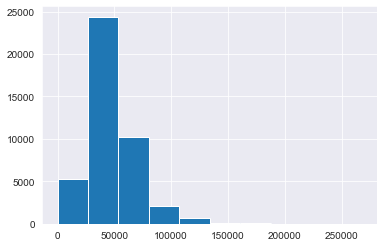

In [47]:
# To check the distribution of median income #薪水分布圖 histogram
plt.hist(merged_df_new["EARN_NE_MDN_3YR"].values)
plt.show()
# plt.hist(np.log(merged_df_linear["EARN_NE_MDN_3YR"].values))
# plt.show()

# Perform Linear Regression to predict

In [48]:
Y_linear = merged_df_new[["EARN_NE_MDN_3YR"]]
# Y_linear["MD_EARN_WNE"] = np.log(merged_df_linear["MD_EARN_WNE"])
X_linear = merged_df_new.drop(columns="EARN_NE_MDN_3YR")

X_train = X_linear[:int(0.8*X_linear.shape[0])] 
X_test = X_linear[int(0.8*X_linear.shape[0]):]

Y_train = Y_linear[:int(0.8*Y_linear.shape[0])]
Y_test = Y_linear[int(0.8*Y_linear.shape[0]):]

reg = LinearRegression().fit(X_train, Y_train) 
  
y_pred_reg = reg.predict(X_test)

result_LR = [metrics.r2_score(Y_test, y_pred_reg), 
             metrics.mean_absolute_error(Y_test, y_pred_reg),
             metrics.mean_squared_error(Y_test, y_pred_reg),
             np.sqrt(metrics.mean_squared_error(Y_test, y_pred_reg))]

# regressor.score(X_train, Y_train)
print("R Squared Score", metrics.r2_score(Y_test, y_pred_reg))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_reg))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_reg))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_reg)))

df = pd.DataFrame({'Actual Student Income': Y_test["EARN_NE_MDN_3YR"], 'Predicted Student Income': y_pred_reg.flatten()})
df.head()
# R squared 精確度 離實際預測數值多遠 愈接近1越好

R Squared Score -7.096271626557572e+19
Mean Absolute Error: 44664776201182.88
Mean Squared Error: 3.2644854700515483e+28
Root Mean Squared Error: 180678871760135.47


,Actual Student Income,Predicted Student Income
36284,46832.0,52572.3125
36285,46567.0,52091.3125
36286,49864.0,51414.3125
36287,42308.0,51615.3125
36288,63432.0,41318.8125


## Perform Ridge

In [49]:
reg_ridge = Ridge(alpha=30).fit(X_train, Y_train) 
y_pred_ridge = reg_ridge.predict(X_test)



print("R Squared Score", metrics.r2_score(Y_test, y_pred_ridge))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_ridge))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_ridge))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_ridge)))

df = pd.DataFrame({'Actual Student Income': Y_test["EARN_NE_MDN_3YR"], 'Predicted Student Income': y_pred_ridge.flatten()})
df.head()

R Squared Score 0.5658305282192728
Mean Absolute Error: 10094.716472077554
Mean Squared Error: 199730225.49810377
Root Mean Squared Error: 14132.594436199737


,Actual Student Income,Predicted Student Income
36284,46832.0,51699.046206
36285,46567.0,51625.095021
36286,49864.0,51521.075771
36287,42308.0,51551.956486
36288,63432.0,41530.351009


# Perform Sparse Regression (LASSO)


In [50]:
lasso = Lasso(alpha=9)  
lasso.fit(X_train, Y_train) 
y_pred_lasso = lasso.predict(X_test)

result_LASSO = [metrics.r2_score(Y_test, y_pred_lasso), 
             metrics.mean_absolute_error(Y_test, y_pred_lasso),
             metrics.mean_squared_error(Y_test, y_pred_lasso),
             np.sqrt(metrics.mean_squared_error(Y_test, y_pred_lasso))]

print("R Squared Score", metrics.r2_score(Y_test, y_pred_lasso))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_lasso))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_lasso))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_lasso)))

df = pd.DataFrame({'Actual': Y_test["EARN_NE_MDN_3YR"], 'Predicted': y_pred_lasso.flatten()})
df.head()


R Squared Score 0.5812461091785531
Mean Absolute Error: 9913.449173721048
Mean Squared Error: 192638622.6533595
Root Mean Squared Error: 13879.431640141447


,Actual,Predicted
36284,46832.0,51748.046925
36285,46567.0,51740.170211
36286,49864.0,51729.090877
36287,42308.0,51732.380054
36288,63432.0,41542.368470


## Decision Tree Regressor


In [51]:
Y_train.shape, Y_test.shape

((34361, 1), (8591, 1))

R Squared Score 0.2642750608269143
Mean Absolute Error: 14744.723340211385
Mean Squared Error: 338454261.657146
Root Mean Squared Error: 18397.126451083222


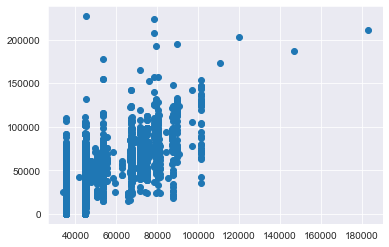

In [52]:
model_dt = DecisionTreeRegressor(max_depth=6,min_samples_leaf=5).fit(X_train,Y_train)
y_pred_dt=model_dt.predict(X_test)

result_DT = [metrics.r2_score(Y_test, y_pred_dt), 
             metrics.mean_absolute_error(Y_test, y_pred_dt),
             metrics.mean_squared_error(Y_test, y_pred_dt),
             np.sqrt(metrics.mean_squared_error(Y_test, y_pred_dt))]

print("R Squared Score", metrics.r2_score(Y_test, y_pred_dt))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_dt))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_dt))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_dt)))

df = pd.DataFrame({'Actual': Y_test["EARN_NE_MDN_3YR"], 'Predicted': y_pred_dt.flatten()})
df.head()

# Accuracy of this decision tree
plt.scatter(y_pred_dt, Y_test)

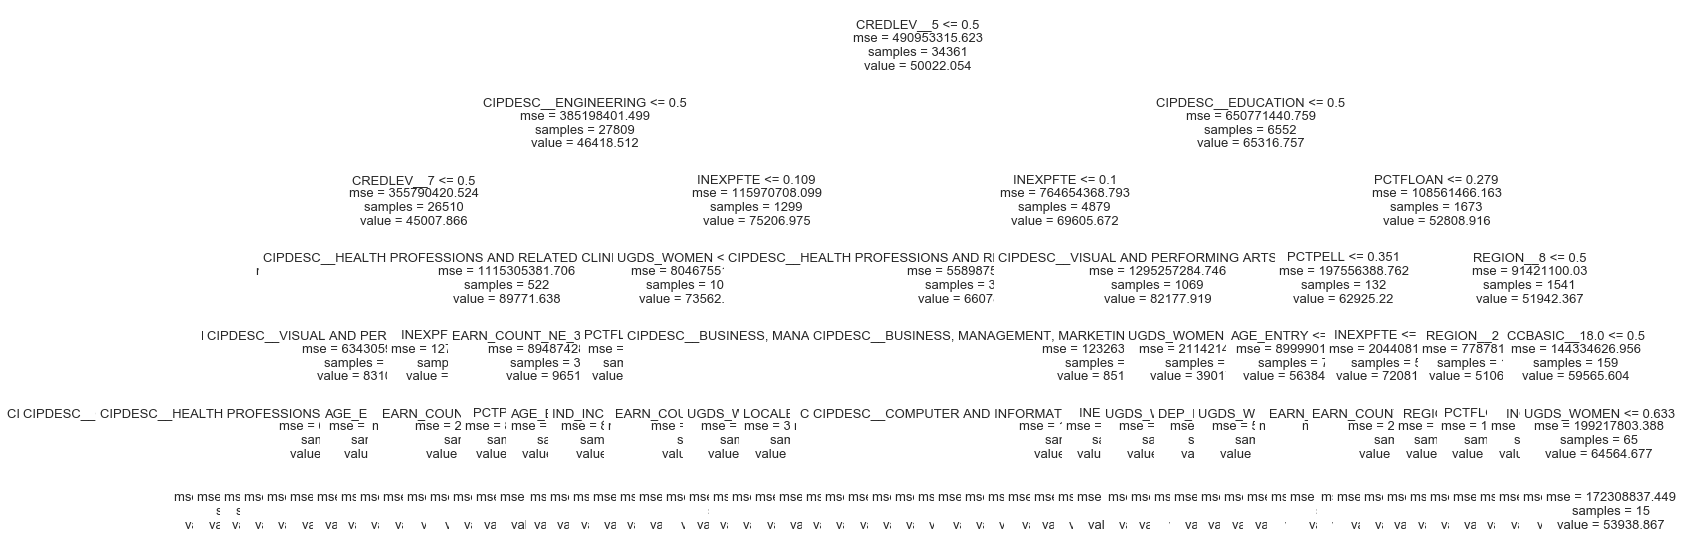

In [53]:
plt.figure(figsize=(25,10))
plot_tree(model_dt,feature_names=list(X_train), fontsize=13)
plt.show()

In [54]:
print("RMSE for Decision Tree: {}".format(np.sqrt(np.mean(((Y_test["EARN_NE_MDN_3YR"]-y_pred_dt))**2))))


RMSE for Decision Tree: 18397.126451083255


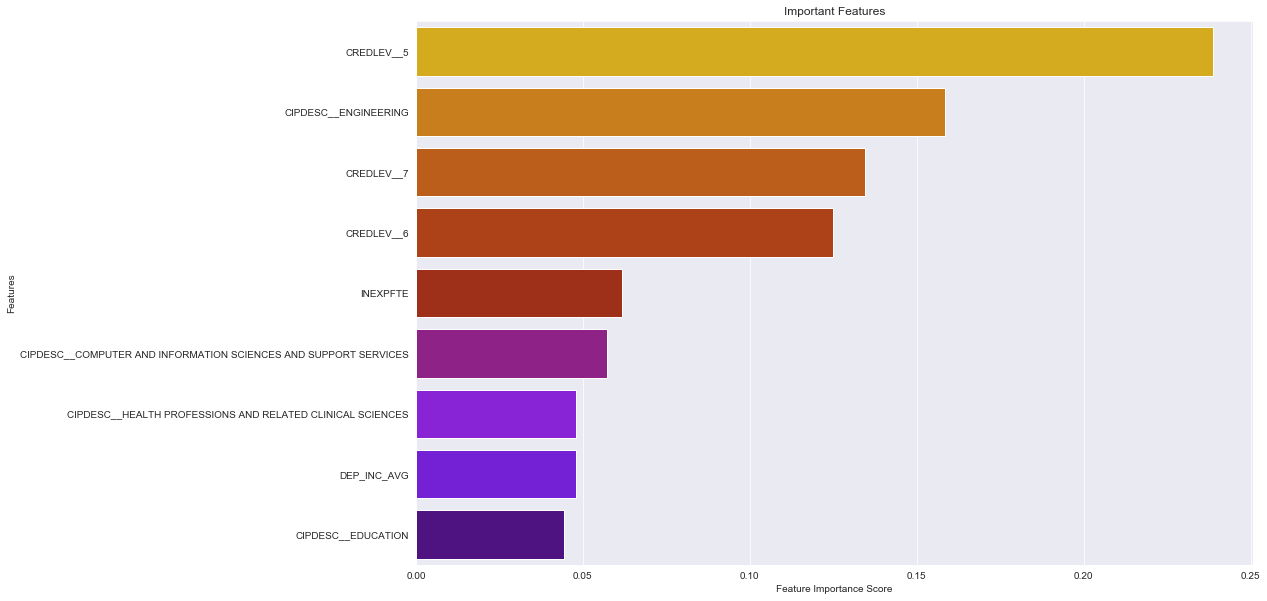

In [55]:
def plot_imp_features(feature_imp):
    plt.figure(figsize=(15,10))
    sns.barplot(x=feature_imp, y=feature_imp.index, palette = sns.color_palette('gnuplot_r', len(feature_imp)))
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Important Features")
    plt.show()
    
feature_imp = pd.Series(model_dt.feature_importances_, index=list(X_train.columns)).sort_values(ascending=False)[:9]
plot_imp_features(feature_imp)


## Perform Random Forest

In [56]:
model = RandomForestRegressor(n_estimators=1000,max_features=10,max_depth=4).fit(X_train,Y_train)
y_pred_RT=model.predict(X_test)

result_RT = [metrics.r2_score(Y_test, y_pred_RT), 
             metrics.mean_absolute_error(Y_test, y_pred_RT),
             metrics.mean_squared_error(Y_test, y_pred_RT),
             np.sqrt(metrics.mean_squared_error(Y_test, y_pred_RT))]

print("R Squared Score", metrics.r2_score(Y_test, y_pred_RT))
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_RT))  # 跟scale有關
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_RT))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_RT)))

df = pd.DataFrame({'Actual': Y_test["EARN_NE_MDN_3YR"], 'Predicted': y_pred_RT.flatten()})
df.head()

R Squared Score 0.29664017240013807
Mean Absolute Error: 13900.471450065888
Mean Squared Error: 323565395.7811592
Root Mean Squared Error: 17987.92360949866


,Actual,Predicted
36284,46832.0,53648.070579
36285,46567.0,53624.067146
36286,49864.0,53444.958289
36287,42308.0,53461.898921
36288,63432.0,50668.215556


In [57]:
print("RMSE for Random Forest: {}".format(np.sqrt(np.mean(((Y_test["EARN_NE_MDN_3YR"]-y_pred_RT))**2))))


RMSE for Random Forest: 17987.92360949868


In [149]:
dir(GBT)

['_SUPPORTED_LOSS',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_initialized',
 '_check_n_features',
 '_check_params',
 '_clear_state',
 '_compute_partial_dependence_recursion',
 '_estimator_type',
 '_fit_stage',
 '_fit_stages',
 '_get_param_names',
 '_get_tags',
 '_init_state',
 '_is_initialized',
 '_make_estimator',
 '_more_tags',
 '_raw_predict',
 '_raw_predict_init',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_resize_state',
 '_rng',
 '_staged_raw_predict',
 '_validate_data',
 '_va